Matthew Virgin <br>
ECE 491 <br>
Final Project <br>
15 December 2023 <br>

Assuming you have pulled the github, you should only have to run this code. Otherwise, you'll have to make sure you have training and testing folders with 4 folders named for the 4 tumors inside each. Note that I also renamed
the "normal" folder in the "Data" folder to "no_tumor" after extracting archive.zip

In [1]:
import os

# Base directories
curr_dir = os.getcwd()
train_folder = os.path.join(curr_dir, "Training")
test_folder = os.path.join(curr_dir, "Testing")

tumor_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
train_dirs = []

# function that takes a parent folder name and a list of its child folder names and
# returns a list containing the proper directory names
def nameFolders(parent_name, child_name_list):
    dirs = []
    for name in child_name_list:
        full_path = os.path.join(parent_name, name)
        dirs.append(full_path)
    return dirs

# list of each train directory
train_dirs = nameFolders(train_folder, tumor_names)

# list of each test directory
test_dirs = nameFolders(test_folder, tumor_names)


In [2]:
# Put the images from the "Data" folder into the correct places in the 
# "Training" and "Testing" folders

from sklearn.model_selection import train_test_split
import shutil

no_tumors = os.path.join(train_folder, "no_tumor")
data_folder = os.path.join(curr_dir, "Data")
# Note: I renamed the "normal" folder in "Data" to "no_tumor" for consistency
data_dirs = nameFolders(data_folder, tumor_names)

# splits subchildren into train and test sets,
# moving their contents to the provided locations
def split_and_move(children):
    train_ratio = 0.6
    for i in range(len(children)):
        
        # list images in folder
        all_images = [f for f in os.listdir(children[i]) if f.endswith('.jpg')]

        train_images, test_images = train_test_split(all_images, train_size=train_ratio, random_state=42)

        for image in train_images:
            shutil.move(os.path.join(children[i], image), os.path.join(train_dirs[i], image))

        for image in test_images:
            shutil.move(os.path.join(children[i], image), os.path.join(test_dirs[i], image))


# only do this if we haven't yet
if (len(os.listdir(no_tumors)) == 0):
    split_and_move(data_dirs)

In [3]:
# function to print the length of each directory
def print_directory_lengths(directory, name):
    files = os.listdir(directory)
    print(f"{name} directory ({directory}): {len(files)} files")
    return len(files)

train_samples = 0
test_samples = 0

# print the length of each training directory
for i in range(len(train_dirs)):
    train_samples = train_samples + print_directory_lengths(train_dirs[i], "train " + tumor_names[i])
    
# print the length of each test directory
for i in range(len(test_dirs)):
    test_samples = test_samples + print_directory_lengths(test_dirs[i], "test " + tumor_names[i])

train glioma_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Training\glioma_tumor): 540 files
train meningioma_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Training\meningioma_tumor): 547 files
train no_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Training\no_tumor): 262 files
train pituitary_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Training\pituitary_tumor): 506 files
test glioma_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Testing\glioma_tumor): 361 files
test meningioma_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Testing\meningioma_tumor): 366 files
test no_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Testing\no_tumor): 176 files
test pituitary_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Testing\pituitary_tumor): 338 files


train samples


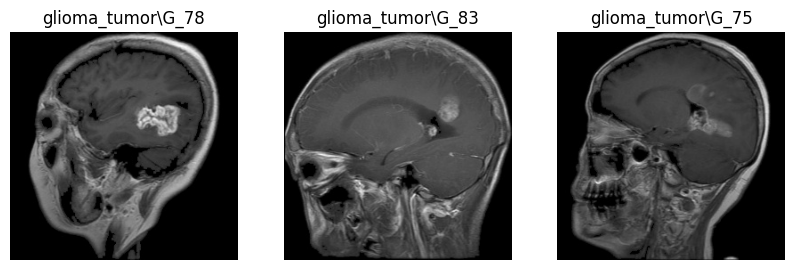

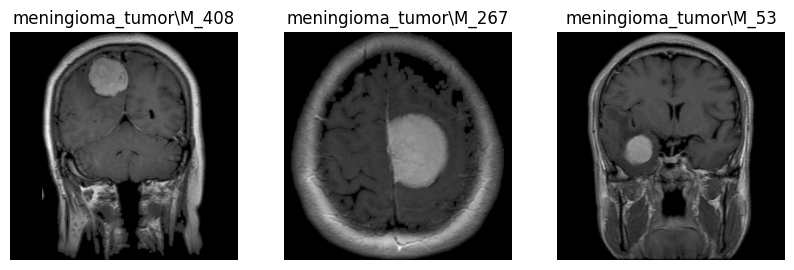

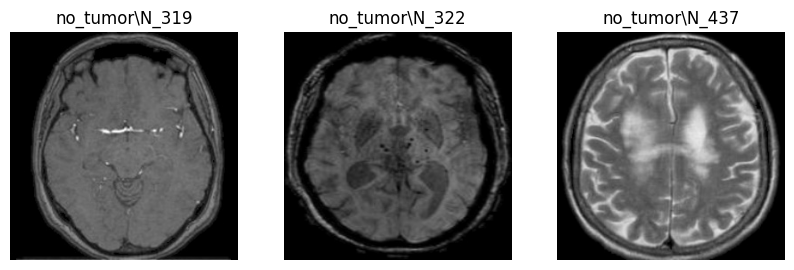

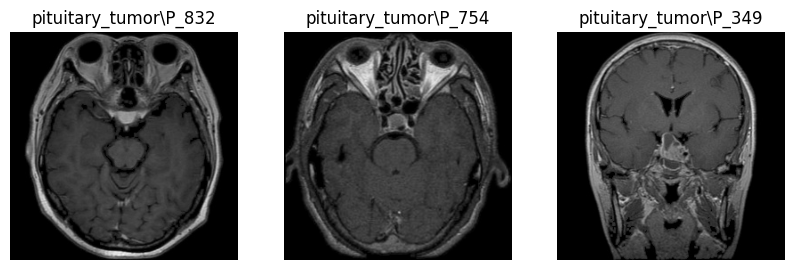

test samples


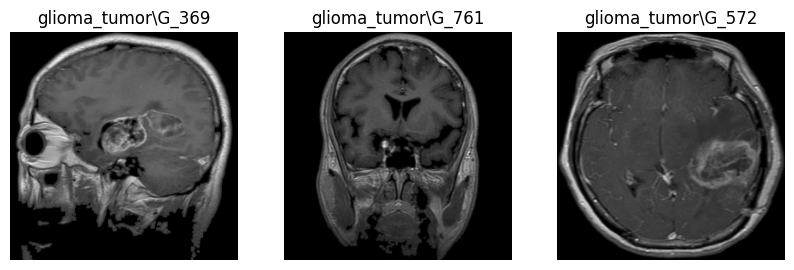

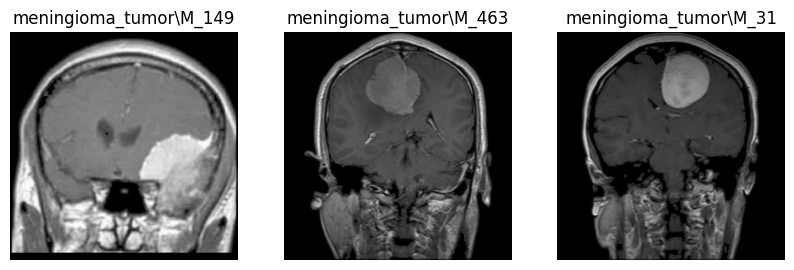

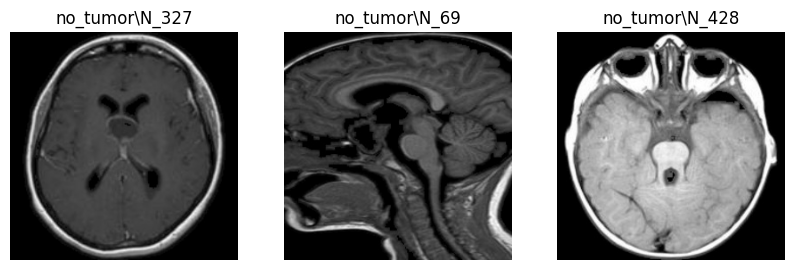

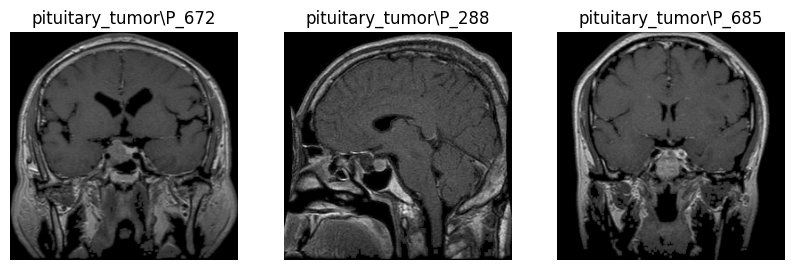

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Function to display three random images from a directory
def display_random_images(directory):
    files = os.listdir(directory)
    random_images = random.sample(files, 3)

    # Plot the random images
    plt.figure(figsize=(10, 5))
    for i, image_file in enumerate(random_images, 1):
        image_path = os.path.join(directory, image_file)

        # get the directory index for clearer labels
        second_to_last_backslash_index = image_path.rfind('\\', 0, image_path.rfind('\\'))

        plt.subplot(1, 3, i)
        img = mpimg.imread(image_path)
        plt.imshow(img)

        # title of each image includes tumor type and image name, cut off .jpg
        plt.title(f"{image_path[second_to_last_backslash_index+1:-4]}")

        plt.axis("off")

    plt.show()

# Display train samples
print("train samples")
for i in range(len(train_dirs)):
    display_random_images(train_dirs[i])

# Display test samples
print("test samples")
for i in range(len(test_dirs)):
    display_random_images(test_dirs[i])

Building the model:

In [5]:
import numpy as np
import tensorflow as tf
import math
from keras import layers
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import preprocess_input
from keras.callbacks import LearningRateScheduler

img_size = 256 
num_classes = 4
BATCH_SIZE = 20

pre_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape = (img_size, img_size, 3)   # we fabricate the two extra channels
)

# freeze model
pre_model.trainable = False

# build top layers
x = pre_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

top_dropout_rate = 0.5
x = layers.Dropout(top_dropout_rate)(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)

# Configure and compile the model
model = Model(inputs = pre_model.input, outputs = outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])

## prepare train and test generators
# train gen has augmentations like rotations and flips
train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_folder, # This is the source directory for training images
        batch_size= BATCH_SIZE,
        shuffle = True,
        color_mode="rgb",       # force 3 channels for use w efficientnet
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        test_folder,
        batch_size= BATCH_SIZE,
        shuffle = True,
	color_mode="rgb",
        class_mode='categorical')

## callbacks
# model checkpoint
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', mode='min', save_best_only=True)

# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # Monitor the validation loss
                                        patience=12,          # Number of epochs with no improvement after which training will be stopped
				        restore_best_weights=True)      # Restore best weights from that period

# learning rate scheduler
def scheduler(epoch, lr):
	initial_lrate = 0.001
	drop = 0.1
	epochs_drop = 10
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lr_schedule = LearningRateScheduler(scheduler)

history = model.fit(
      train_generator,
      steps_per_epoch=int(np.ceil(train_samples / float(BATCH_SIZE))),
      epochs=50,
      validation_data=validation_generator,
      validation_steps=int(np.ceil(test_samples / float(BATCH_SIZE))),
      callbacks = [cp, es, lr_schedule],
      verbose=1)

Found 1855 images belonging to 4 classes.
Found 1241 images belonging to 4 classes.
Epoch 1/50
93/93 [==============================] - 28s 210ms/step - loss: 1.0461 - acc: 0.5402 - val_loss: 0.6348 - val_acc: 0.7607 - lr: 0.0010
Epoch 2/50
93/93 [==============================] - 18s 190ms/step - loss: 0.7750 - acc: 0.6976 - val_loss: 0.5634 - val_acc: 0.7776 - lr: 0.0010
Epoch 3/50
93/93 [==============================] - 18s 191ms/step - loss: 0.6484 - acc: 0.7326 - val_loss: 0.5502 - val_acc: 0.7857 - lr: 0.0010
Epoch 4/50
93/93 [==============================] - 17s 187ms/step - loss: 0.6352 - acc: 0.7493 - val_loss: 0.4683 - val_acc: 0.8195 - lr: 0.0010
Epoch 5/50
93/93 [==============================] - 17s 183ms/step - loss: 0.6002 - acc: 0.7553 - val_loss: 0.5088 - val_acc: 0.8026 - lr: 0.0010
Epoch 6/50
93/93 [==============================] - 17s 185ms/step - loss: 0.5884 - acc: 0.7569 - val_loss: 0.5868 - val_acc: 0.7695 - lr: 0.0010
Epoch 7/50
93/93 [======================

Analysis

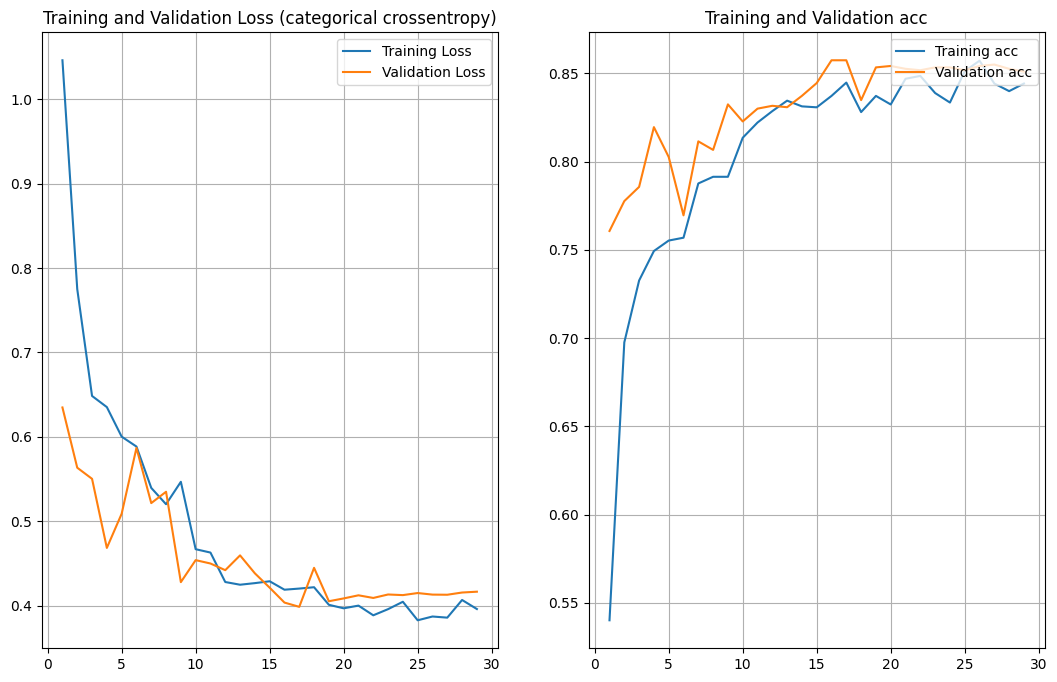

In [7]:
def plot_history(history, SKIP):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs_range = range(1, len(loss) + 1)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range[SKIP:], loss[SKIP:], label='Training Loss')
    plt.plot(epochs_range[SKIP:], val_loss[SKIP:], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (categorical crossentropy)')
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range[SKIP:], acc[SKIP:], label='Training acc')
    plt.plot(epochs_range[SKIP:], val_acc[SKIP:], label='Validation acc')
    plt.legend(loc='upper right')
    plt.title('Training and Validation acc')

    plt.grid()
    plt.show()

plot_history(history, 0)

Fine-tuning

In [8]:
# Unfreeze the base model and train end to end
pre_model.trainable = True

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=int(np.ceil(train_samples / float(BATCH_SIZE))),
      epochs=35,
      validation_data=validation_generator,
      validation_steps=int(np.ceil(test_samples / float(BATCH_SIZE))),
      callbacks = [cp, es, lr_schedule],
      verbose=1)

Epoch 1/35
93/93 [==============================] - 43s 341ms/step - loss: 0.8273 - acc: 0.7224 - val_loss: 0.4746 - val_acc: 0.8509 - lr: 0.0010
Epoch 2/35
93/93 [==============================] - 30s 318ms/step - loss: 0.4857 - acc: 0.8248 - val_loss: 0.4132 - val_acc: 0.8574 - lr: 0.0010
Epoch 3/35
93/93 [==============================] - 31s 329ms/step - loss: 0.4416 - acc: 0.8447 - val_loss: 0.3461 - val_acc: 0.8670 - lr: 0.0010
Epoch 4/35
93/93 [==============================] - 31s 327ms/step - loss: 0.3909 - acc: 0.8642 - val_loss: 0.2460 - val_acc: 0.9347 - lr: 0.0010
Epoch 5/35
93/93 [==============================] - 31s 327ms/step - loss: 0.3356 - acc: 0.8884 - val_loss: 0.2258 - val_acc: 0.9202 - lr: 0.0010
Epoch 6/35
93/93 [==============================] - 31s 327ms/step - loss: 0.3536 - acc: 0.8744 - val_loss: 0.1430 - val_acc: 0.9565 - lr: 0.0010
Epoch 7/35
93/93 [==============================] - 30s 317ms/step - loss: 0.3028 - acc: 0.8965 - val_loss: 0.2383 - val_acc

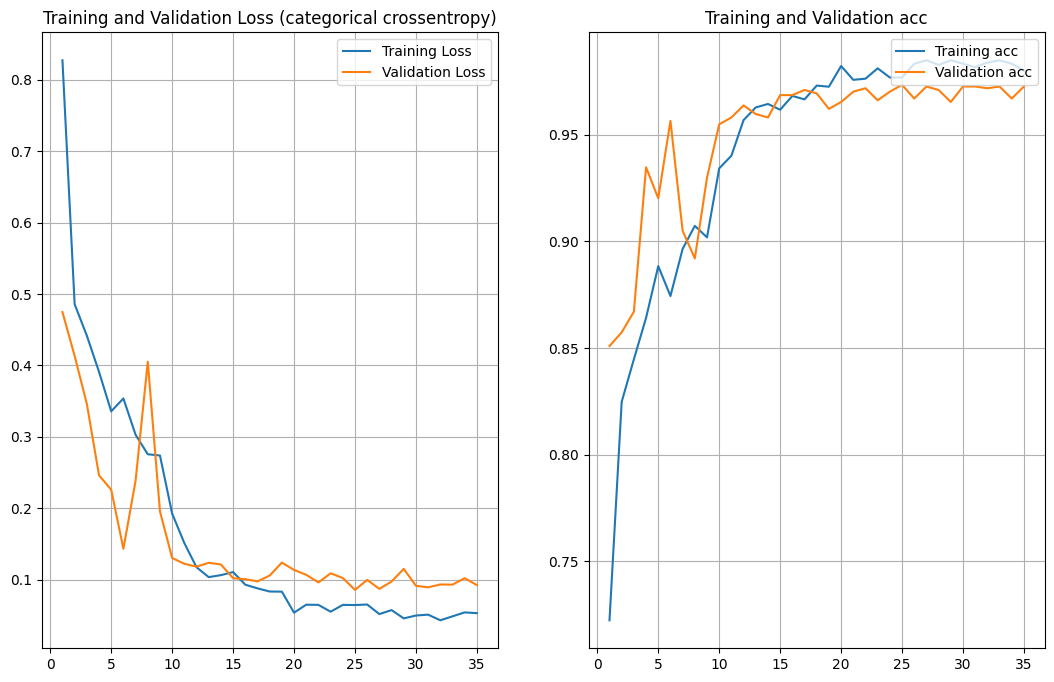

In [10]:
plot_history(history, 0)

93/93 [==============================] - 14s 155ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.99      0.99       540
meningioma_tumor       0.99      0.98      0.99       547
        no_tumor       1.00      1.00      1.00       262
 pituitary_tumor       1.00      1.00      1.00       506

        accuracy                           0.99      1855
       macro avg       0.99      0.99      0.99      1855
    weighted avg       0.99      0.99      0.99      1855



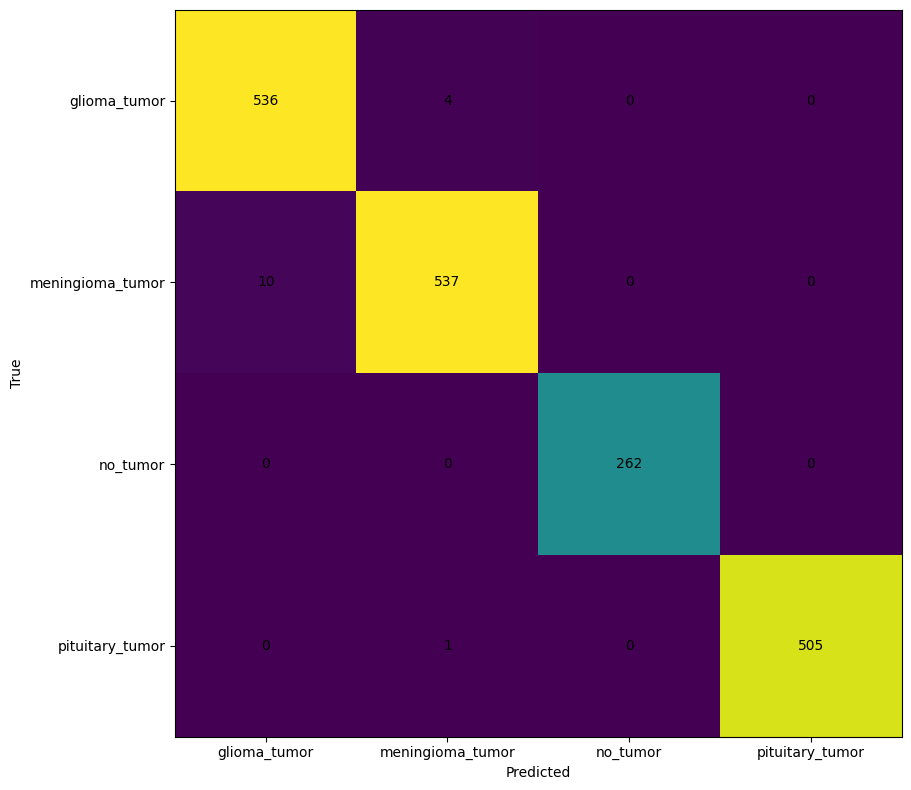

Misclassifications for class "glioma_tumor":


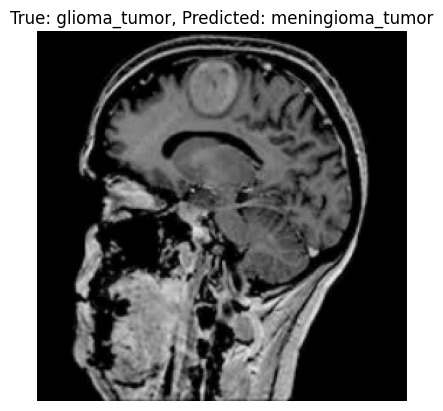

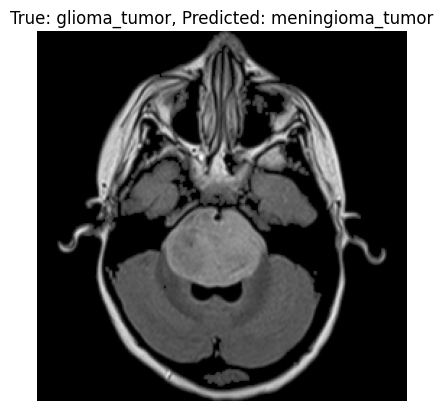

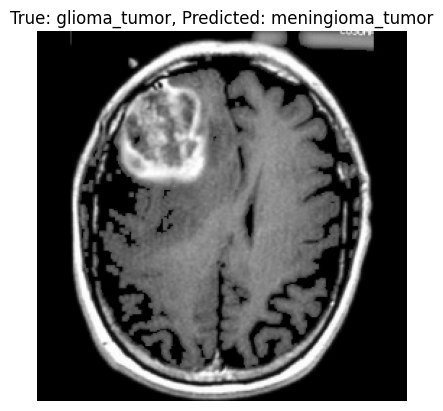

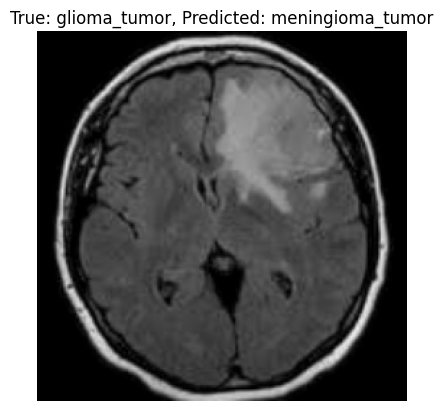

Misclassifications for class "meningioma_tumor":


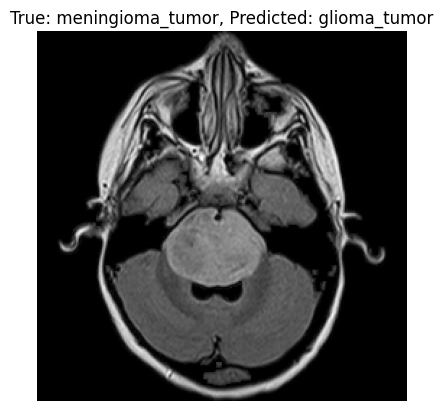

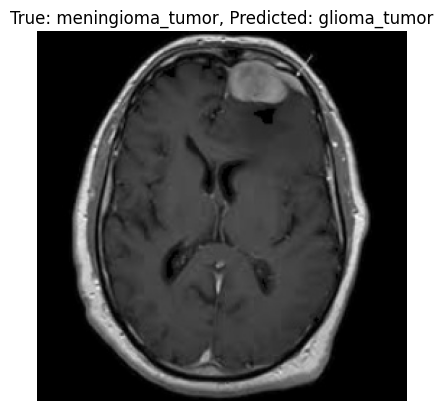

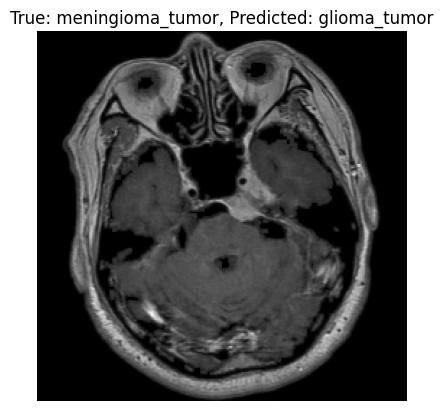

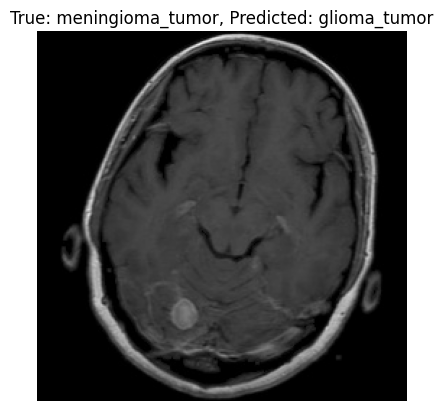

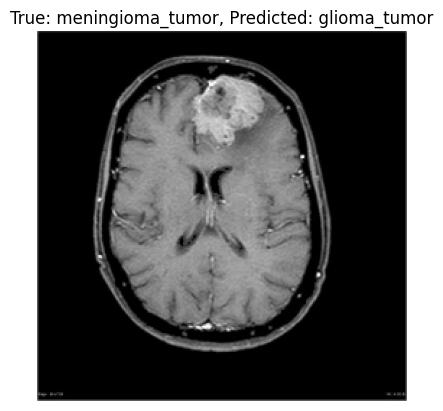

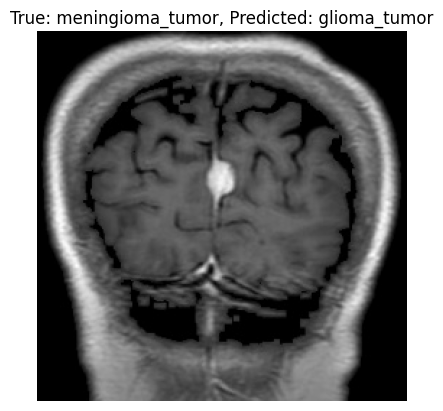

Misclassifications for class "no_tumor":
Misclassifications for class "pituitary_tumor":


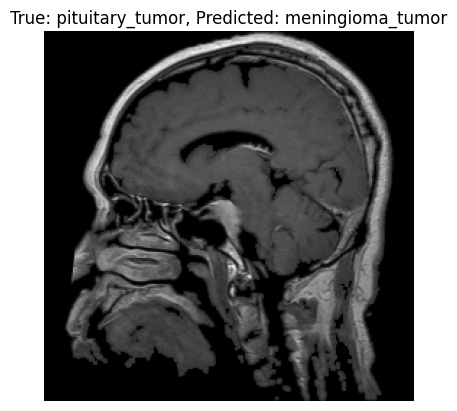

Correctly classified samples for class "glioma_tumor":


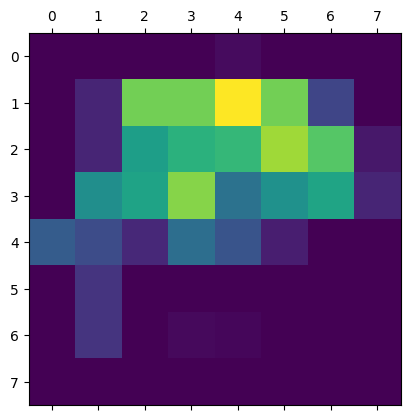

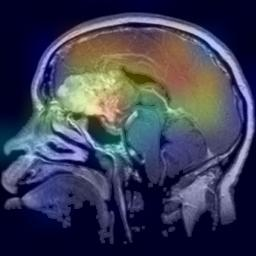

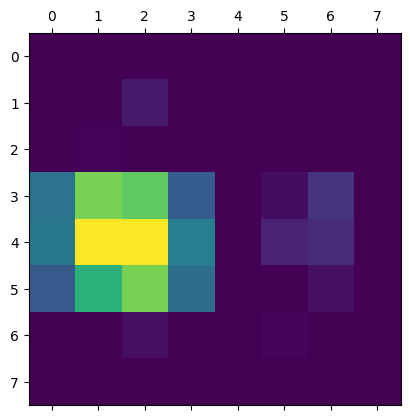

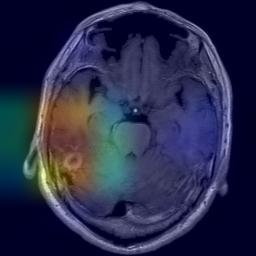

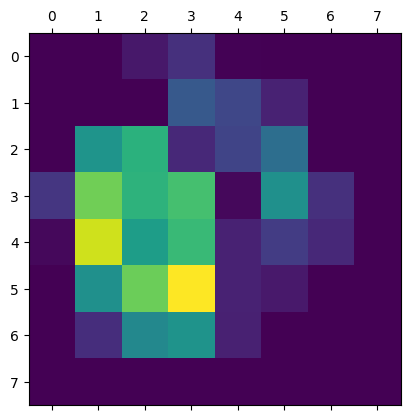

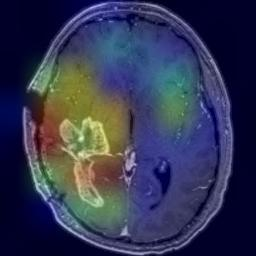

Correctly classified samples for class "meningioma_tumor":


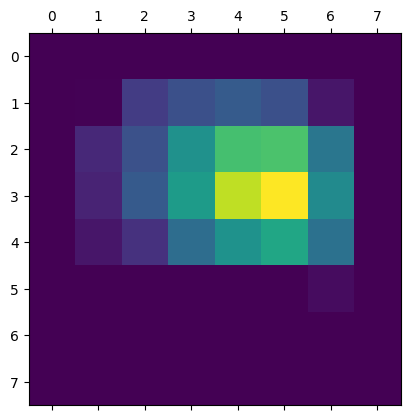

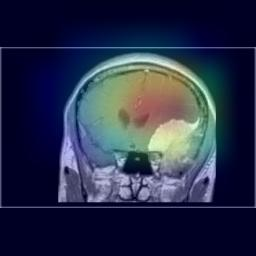

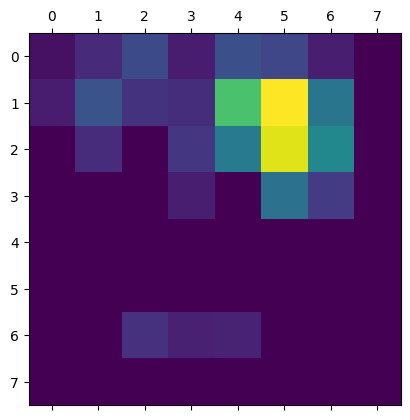

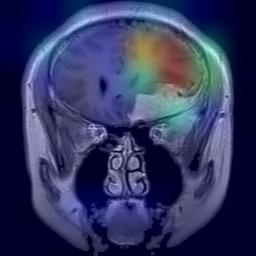

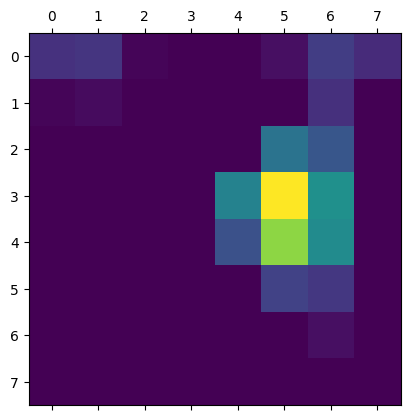

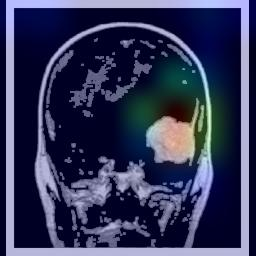

Correctly classified samples for class "no_tumor":


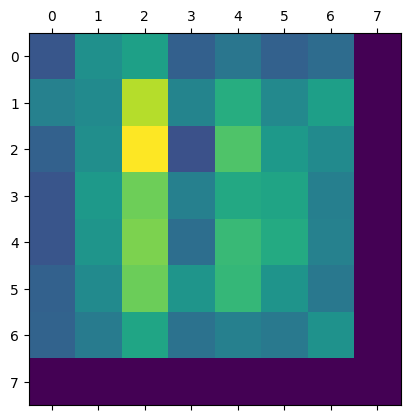

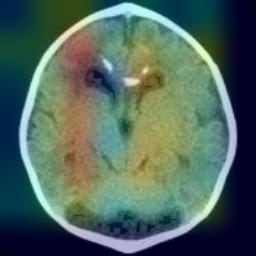

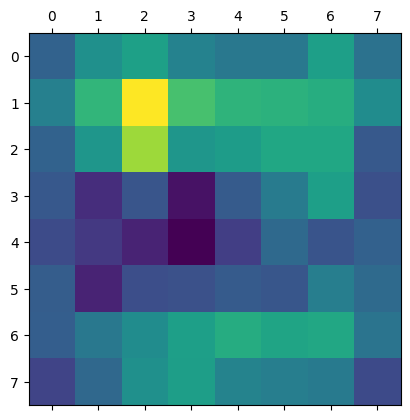

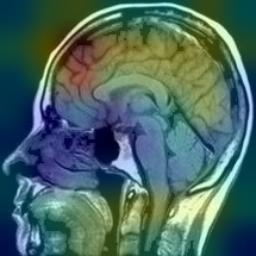

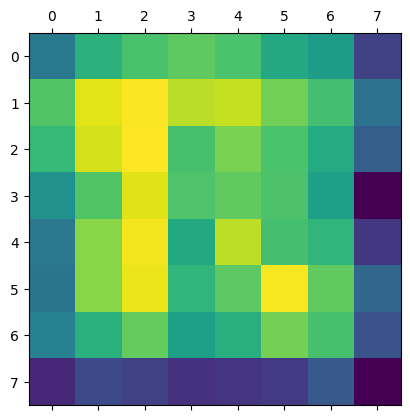

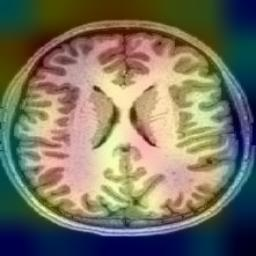

Correctly classified samples for class "pituitary_tumor":


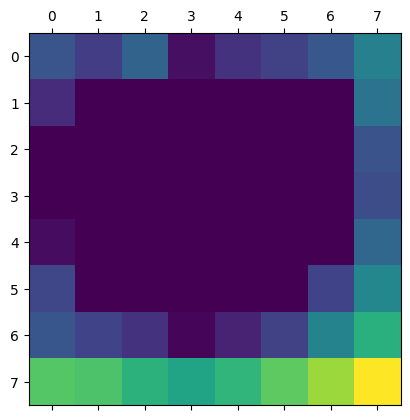

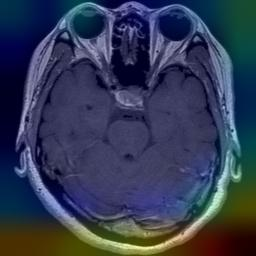

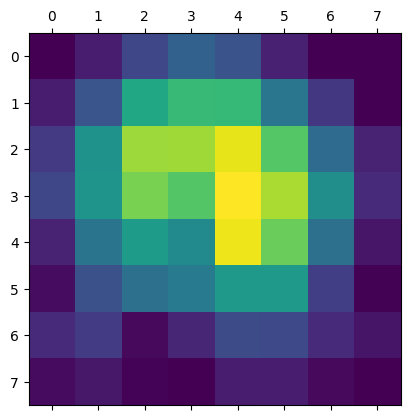

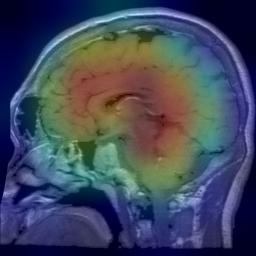

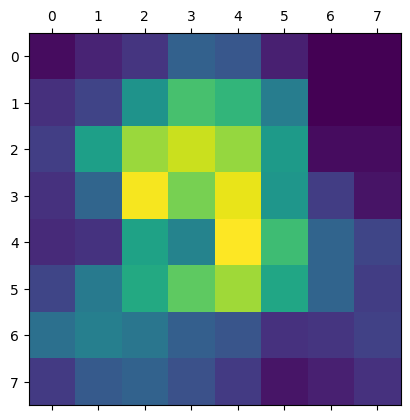

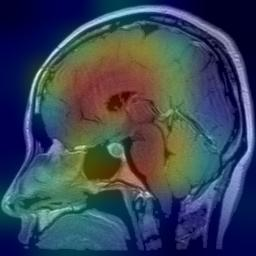

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from IPython.display import Image, display
import matplotlib as mpl

# final convolutinal layer in my model (for use in generating heatmap)
last_conv = "top_conv"

# for heatmaps - from https://keras.io/examples/vision/grad_cam/ 
# NOTE I shouldn't need to preprocess images with effnets preprocess_input
# because my generators already do that
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

# displays first n heatmaps for the correctly identified classes in gen
def show_heatmaps(correct_indices, gen, n):
    for class_idx, indices in correct_indices.items():
        class_name = list(gen.class_indices.keys())[class_idx]
        print(f'Correctly classified samples for class "{class_name}":')
        for j in range(n):
            i = indices[j]
            img_path = gen.filepaths[i]
            img_arr = get_img_array(img_path, size=(img_size, img_size))
            heatmap = make_gradcam_heatmap(img_arr, model, last_conv)
            plt.matshow(heatmap)
            plt.show()
            save_and_display_gradcam(img_path, heatmap)

# takes a generator and a model, makes a prediction and reports the 
# confusion matrix and classification report as well as the first display_num
# misclassified images for each class
#### NOTE: for some reason the report is only correct after the 2nd call!!!!
def matrix_report(gen, model, second, display_num):
    gen.reset()
    class_labels = list(gen.class_indices.keys())

    y_truth = gen.classes
    Y_pred = model.predict(gen)  # shuffle off or results ruined
    y_pred = np.argmax(Y_pred, axis=1)

    cm = confusion_matrix(y_truth, y_pred)

    if second == True:

        print(classification_report(y_truth, y_pred, target_names=class_labels))

        # Plot confusion matrix with class labels
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(cm)

        # Set ticks for class labels
        ax.set_xticks(np.arange(len(class_labels)))
        ax.set_yticks(np.arange(len(class_labels)))

        # Set tick labels
        ax.set_xticklabels(class_labels)
        ax.set_yticklabels(class_labels)

        # Label axes
        plt.xlabel('Predicted')
        plt.ylabel('True')

        # Display the values in each cell
        for i in range(len(class_labels)):
            for j in range(len(class_labels)):
                text = ax.text(j, i, f'{cm[i, j]}', ha='center', va='center', color='black')
        
        plt.tight_layout()
        plt.show()

    if display_num > 0:
        # init dict for storing misclassified indices per class
        incorrect_indices = {class_idx: [] for class_idx in range(len(gen.class_indices))}

        # init dict for storing properly classified indices per class (for heatmaps)
        correct_indices = {class_idx: [] for class_idx in range(len(gen.class_indices))}

        # Find misclassified indices for each class
        for i in range(len(y_truth)):
            true_label = y_truth[i]
            predicted_label = y_pred[i]

            if true_label != predicted_label:
                incorrect_indices[true_label].append(i)
            else:
                correct_indices[true_label].append(i)

        # display them
        for class_idx, misclassified_indices in incorrect_indices.items():
            class_name = class_labels[class_idx]
            print(f'Misclassifications for class "{class_name}":')

            for i in range(min(display_num+1, len(misclassified_indices))):
                index = misclassified_indices[i]

                # Load and display the misclassified image
                img_path = gen.filepaths[index]
                img = plt.imread(img_path)
                plt.imshow(img)
                plt.axis('off')

                # Display true and predicted labels
                true_class = class_labels[y_truth[index]]
                predicted_class = class_labels[y_pred[index]]

                plt.title(f'True: {true_class}, Predicted: {predicted_class}')

                plt.show()

        show_heatmaps(correct_indices, gen, (display_num+1)//2)



train_generator.shuffle = False
matrix_report(train_generator, model, False, 0)
matrix_report(train_generator, model, True, 5)

63/63 [==============================] - 4s 68ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.98      0.98       361
meningioma_tumor       0.97      0.94      0.96       366
        no_tumor       1.00      0.98      0.99       176
 pituitary_tumor       0.95      1.00      0.98       338

        accuracy                           0.97      1241
       macro avg       0.98      0.97      0.98      1241
    weighted avg       0.97      0.97      0.97      1241



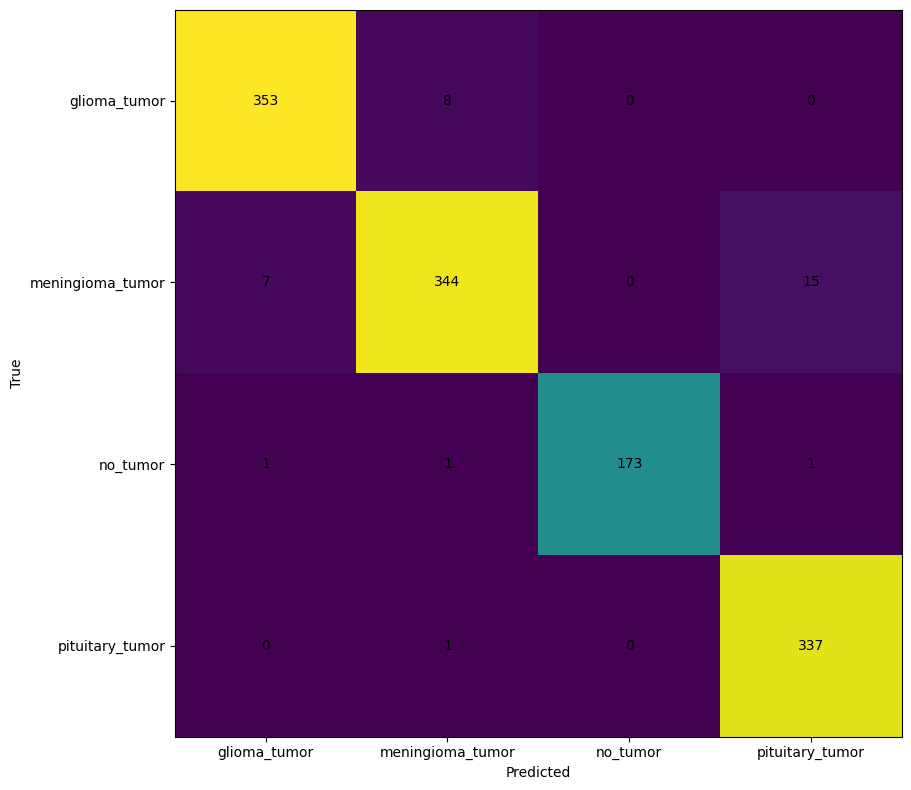

Misclassifications for class "glioma_tumor":


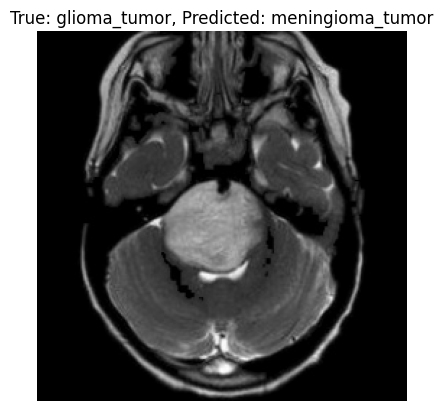

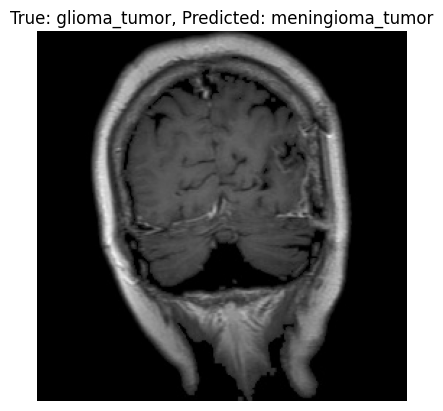

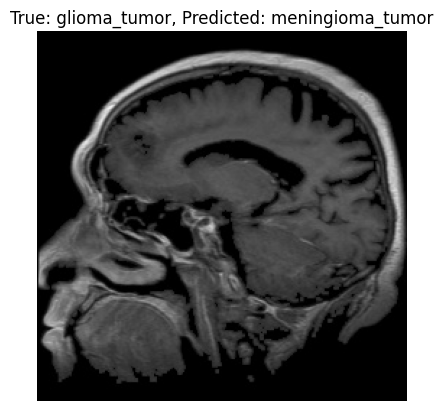

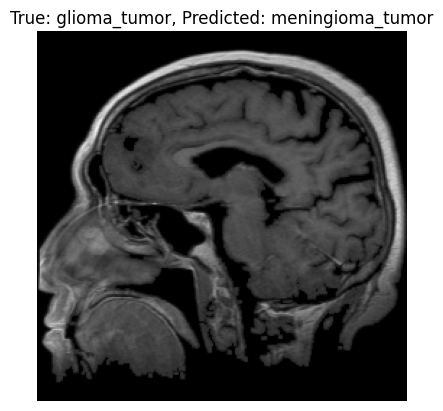

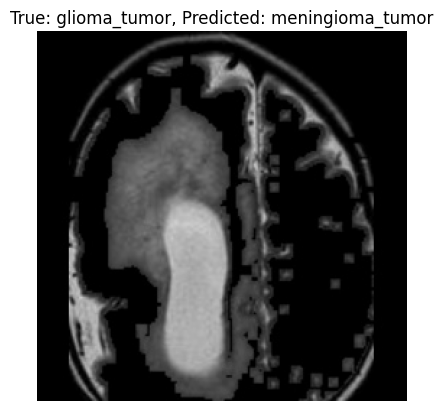

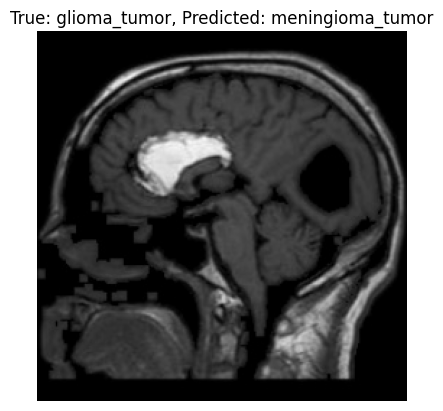

Misclassifications for class "meningioma_tumor":


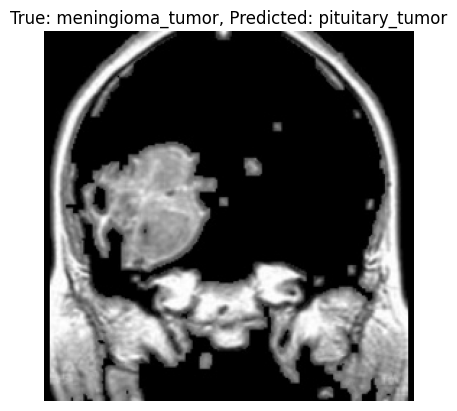

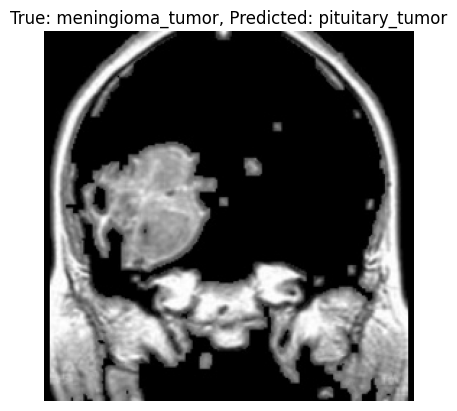

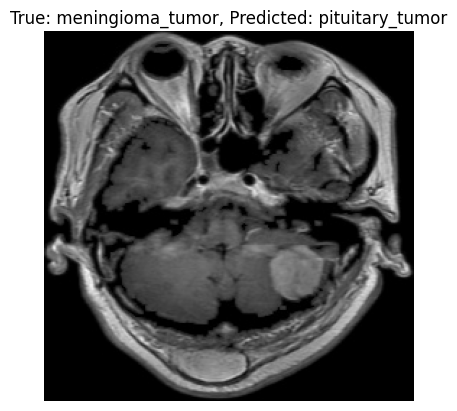

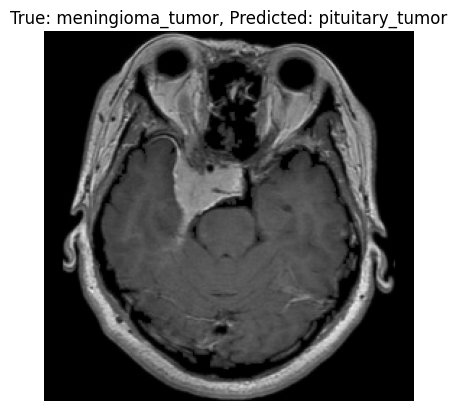

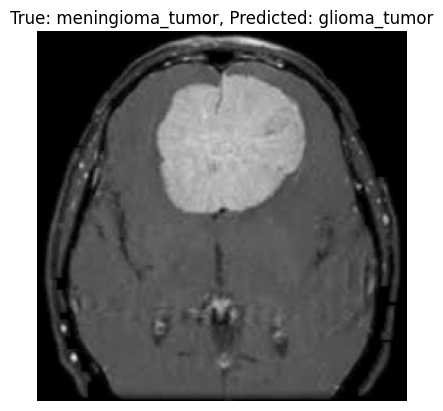

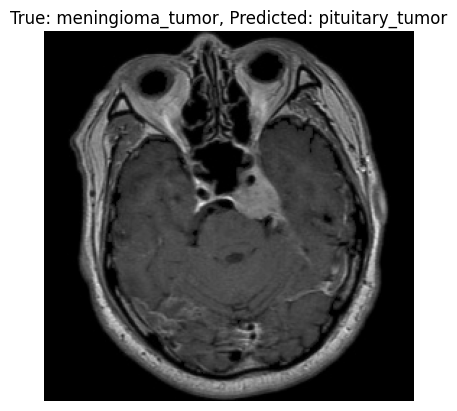

Misclassifications for class "no_tumor":


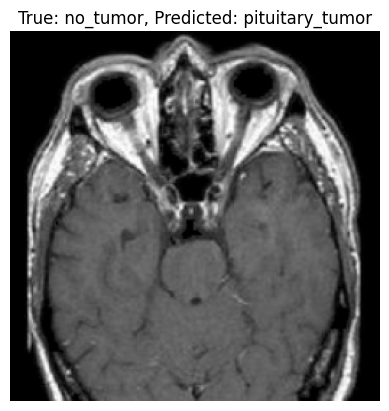

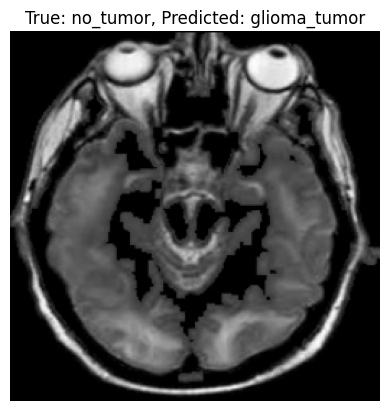

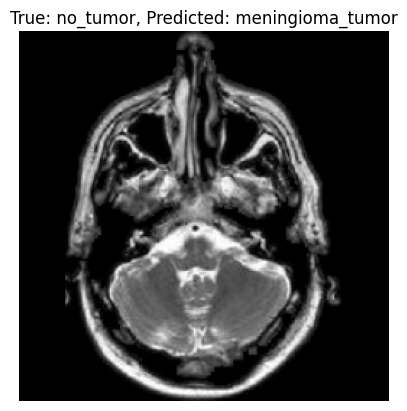

Misclassifications for class "pituitary_tumor":


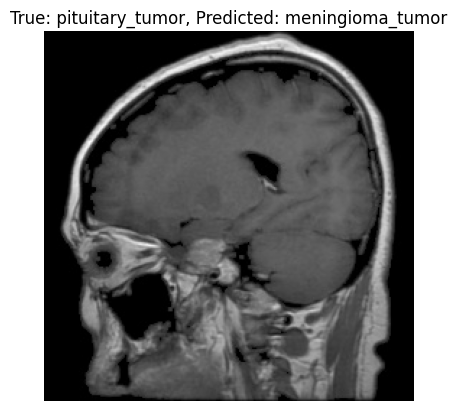

Correctly classified samples for class "glioma_tumor":


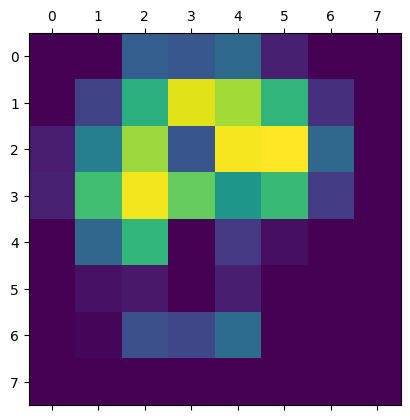

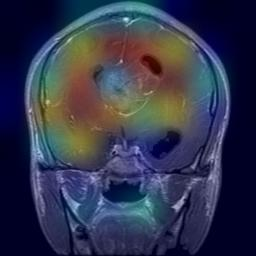

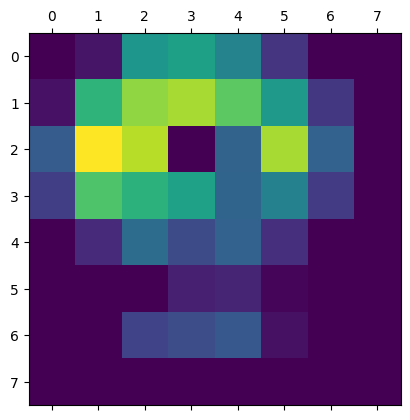

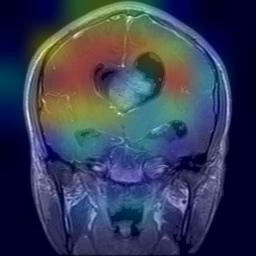

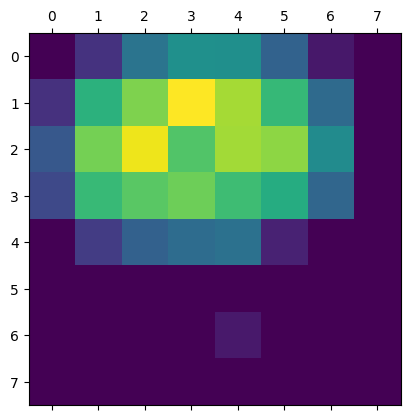

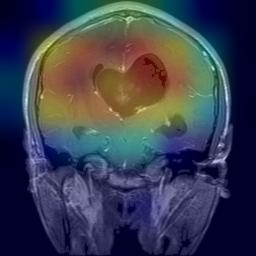

Correctly classified samples for class "meningioma_tumor":


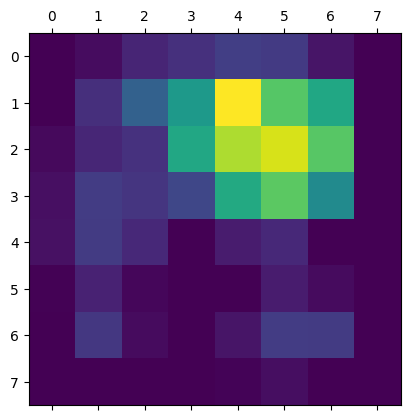

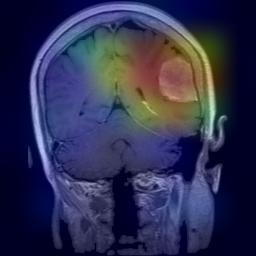

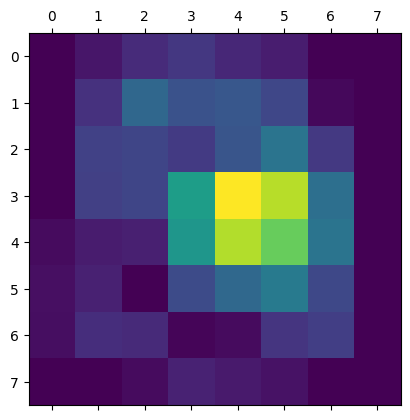

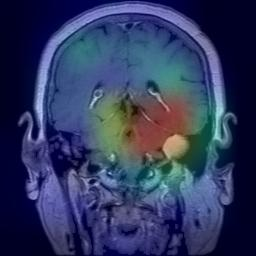

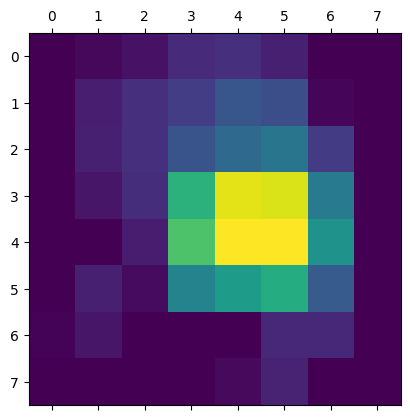

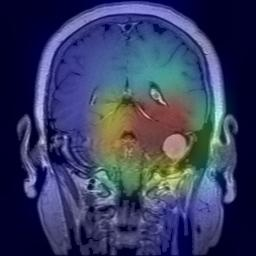

Correctly classified samples for class "no_tumor":


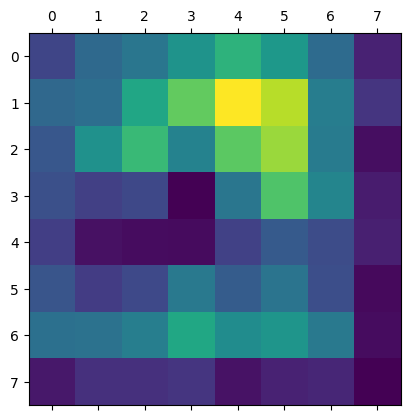

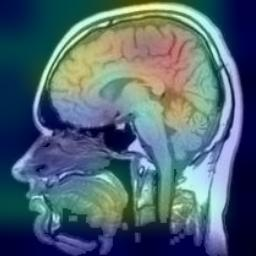

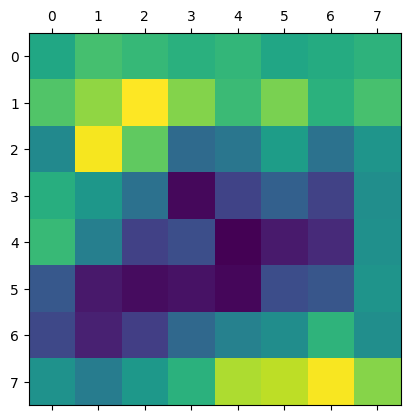

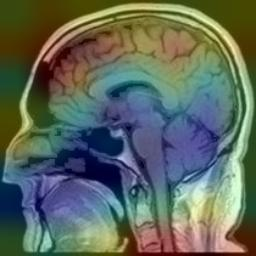

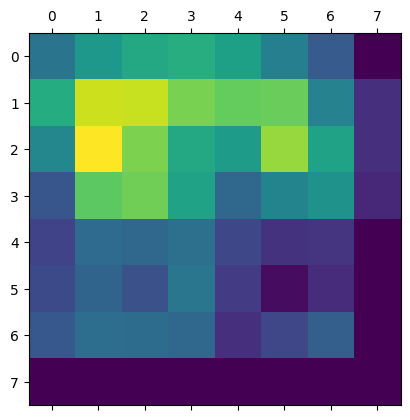

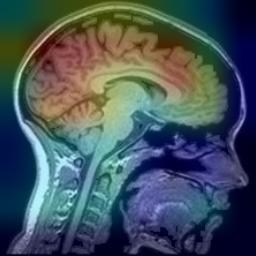

Correctly classified samples for class "pituitary_tumor":


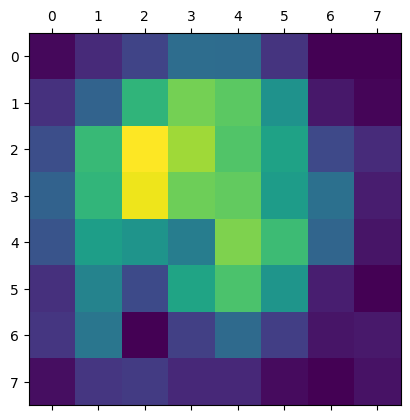

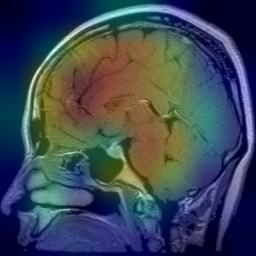

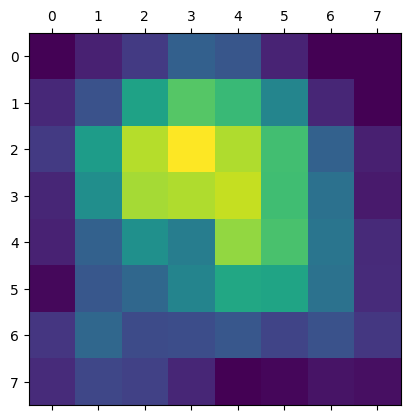

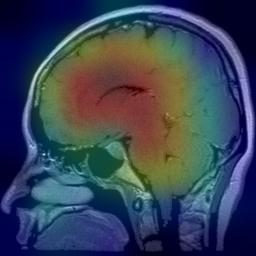

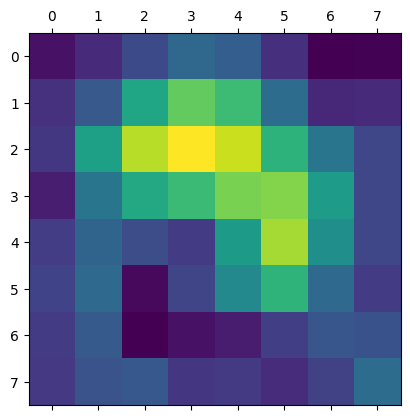

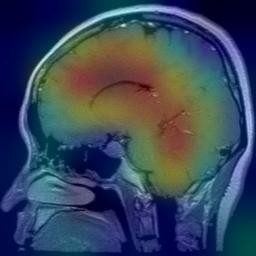

In [36]:
validation_generator.shuffle = False
matrix_report(validation_generator, model, False, 0)
matrix_report(validation_generator, model, True, 5)